# Titanic Dataset Analysis and Decision Tree Implementation



# part 1 EDA

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Titanic--Dataset3.csv")


In [65]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

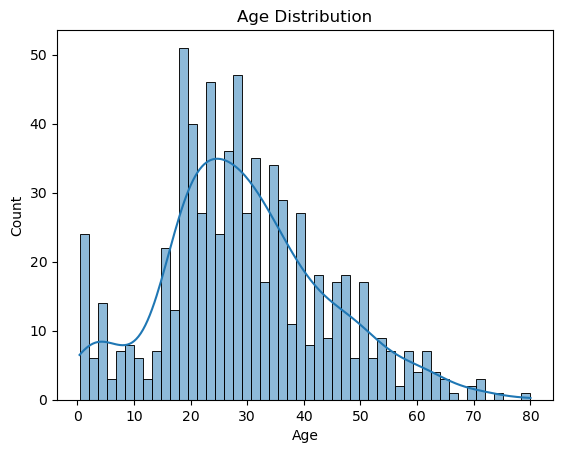

In [66]:
sns.histplot(df['Age'].dropna(), bins=50, kde=True)
plt.title("Age Distribution")
plt.show()

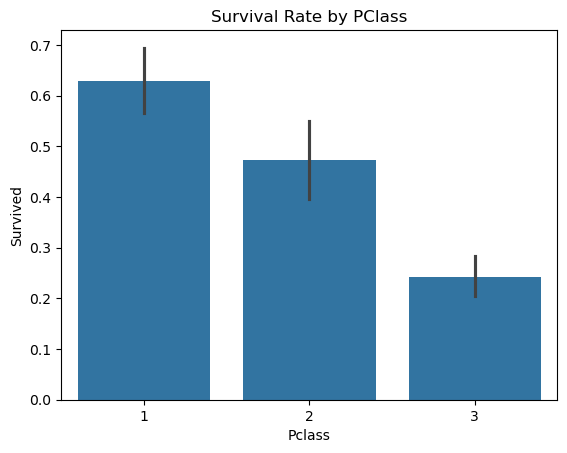

In [67]:
sns.barplot(x="Pclass", y="Survived", data=df)
plt.title("Survival Rate by PClass")
plt.show()

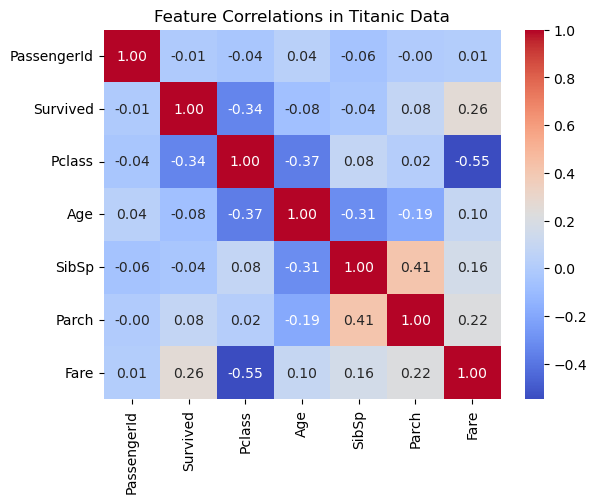

In [68]:
# Compute correlation for numeric columns only (Name remains in df)
corr_matrix = df.select_dtypes(include=['number']).corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations in Titanic Data")
plt.show()


# handling missing values

In [69]:
df['Title'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
# Mapping common titles to median age
title_age_map = df.groupby('Title')['Age'].median().to_dict()
df['Age'] = df.apply(lambda row: title_age_map[row['Title']] if pd.isnull(row['Age']) else row['Age'], axis=1)


In [70]:
# Fill missing Fare values with median of corresponding Pclass
df['Fare'] = df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))


In [71]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


In [58]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
None


In [72]:
df.drop(columns=['Cabin'], inplace=True)

# feature enginenring

In [73]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Categorize Age
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 30,50, 100], labels=['Child', 'Teen', 'young','adult', 'Senior'])


In [74]:
df['FamilySizeGroup'] = df['FamilySize'].map(lambda x: 
    'Single' if x == 1 else 
    'Small Family' if x == 2 or x == 3 else 
    'Normal Family' if x == 4 else 
    'Large Family' if x == 5 else 
    'Really Large Family'
)


# one hot encoding

In [75]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass', 'AgeGroup', 'FamilySizeGroup'], drop_first=True)
df.drop(columns=['Name', 'Ticket', 'Title'], inplace=True)  # Drop irrelevant columns
# Categorize FamilySize



In [76]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PassengerId                          891 non-null    int64  
 1   Survived                             891 non-null    int64  
 2   Age                                  891 non-null    float64
 3   SibSp                                891 non-null    int64  
 4   Parch                                891 non-null    int64  
 5   Fare                                 891 non-null    float64
 6   FamilySize                           891 non-null    int64  
 7   Sex_male                             891 non-null    bool   
 8   Embarked_Q                           891 non-null    bool   
 9   Embarked_S                           891 non-null    bool   
 10  Pclass_2                             891 non-null    bool   
 11  Pclass_3                        

# dt classifier

In [85]:

from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt.fit(X_train, y_train)


y_pred = dt.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves as a file
graph.view()  # Open the visualization


Decision Tree Accuracy: 0.79


'decision_tree.pdf'

# hyper params tuning

In [91]:

param_grid = {
    'max_depth': [2, 4, 6, 8, 10,None],  
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],        
    'criterion': ['gini', 'entropy']     
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Decision Tree Parameters: {grid_search.best_params_}")
best_dt = grid_search.best_estimator_

y_pred_best = best_dt.predict(X_test)
print(f"Optimized Decision Tree Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print(classification_report(y_test, y_pred_best))


Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       105
           1       0.84      0.62      0.71        74

    accuracy                           0.79       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



In [100]:
# Define hyperparameter grid
from sklearn.ensemble import RandomForestClassifier
param_grid_rf = {
    'n_estimators': [10,50, 100, 200, 300],  
    'max_depth': [None, 5, 10, 15],       # Tree depth
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],        # Minimum samples per leaf
    'criterion': ['gini', 'entropy']      # Splitting criterion
}


grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                              param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)


print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_


y_pred_best_rf = best_rf.predict(X_test)
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_test, y_pred_best_rf):.2f}")
print(classification_report(y_test, y_pred_best_rf))


Best Random Forest Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Optimized Random Forest Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



In [93]:
# Select top k best features
from sklearn.feature_selection import SelectKBest, chi2
k_best = SelectKBest(score_func=chi2, k=8)  #
X_new = k_best.fit_transform(X, y)


feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': k_best.scores_})
print(feature_scores.sort_values(by="Score", ascending=False))

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


                                Feature        Score
4                                  Fare  4518.319091
6                              Sex_male    92.702447
10                             Pclass_3    41.553071
18         FamilySizeGroup_Small Family    35.590148
1                                   Age    33.101632
17               FamilySizeGroup_Single    14.640793
15        FamilySizeGroup_Normal Family    14.199652
16  FamilySizeGroup_Really Large Family    10.965515
3                                 Parch    10.097499
12                       AgeGroup_young     9.641906
9                              Pclass_2     6.160767
8                            Embarked_S     5.489205
13                       AgeGroup_adult     4.490897
0                           PassengerId     3.312934
2                                 SibSp     2.581865
11                        AgeGroup_Teen     0.592259
14                      AgeGroup_Senior     0.434885
5                            FamilySize     0.

In [ ]:

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [5, 10, 15,20,25,30],      
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],      
    'criterion': ['gini', 'entropy']     
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                              param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_


y_pred_best_rf = best_rf.predict(X_test)
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_test, y_pred_best_rf):.2f}")
print(classification_report(y_test, y_pred_best_rf))


In [98]:

param_grid_dt = {
    'max_depth': [2, 4, 6, 8, 10,12 ,None],  
    'min_samples_split': [2,3, 5,7 ,10],      
    'min_samples_leaf': [1, 2, 4],        
    'criterion': ['gini', 'entropy']     
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              param_grid_dt, cv=5, scoring='accuracy', n_jobs=-6)
grid_search_dt.fit(X_train, y_train)

print(f"Best Decision Tree Parameters: {grid_search_dt.best_params_}")
best_dt = grid_search_dt.best_estimator_

y_pred_best_dt = best_dt.predict(X_test)
print(f"Optimized Decision Tree Accuracy: {accuracy_score(y_test, y_pred_best_dt):.2f}")
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_best_dt))


Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.82
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



In [95]:
print(f"Final Model Comparison:")
print(f" Decision Tree Accuracy: {accuracy_score(y_test, y_pred_best_dt):.2f}")
print(f" Random Forest Accuracy: {accuracy_score(y_test, y_pred_best_rf):.2f}")


Final Model Comparison:
 Decision Tree Accuracy: 0.82
 Random Forest Accuracy: 0.82
